In [6]:
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta

tickers = ['SPY', 'QQQ', 'MSFT', 'AAPL', 'AMZN']

end_date = datetime.now()
start_date = end_date - timedelta(days=7) 

try:
    a_data = yf.download(
        tickers=tickers,
        start=start_date.strftime('%Y-%m-%d'),
        end=end_date.strftime('%Y-%m-%d'),
        interval="1m"
    )
    
    if a_data.empty:
        print("Error")
        exit() 
        
    print(a_data.head())

    # data to long
    df = a_data.stack(level=1).reset_index()

    df.rename(columns={
        'level_0': 'Datetime',
        'level_1': 'Ticker',  
        'Adj Close': 'Adj_Close' 
    }, inplace=True)
    
    df['Datetime'] = pd.to_datetime(df['Datetime'])

    df.sort_values(by=['Datetime', 'Ticker'], inplace=True)

    print("Long data")
    print(df.head(10)) 


except Exception as e:
    print('Error')

/var/folders/5_/t6j4c_393llc2ffbkjsdr9mr0000gn/T/ipykernel_41909/3456497280.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  a_data = yf.download(
[*********************100%***********************]  5 of 5 completed

Price                           Close                                      \
Ticker                           AAPL        AMZN        MSFT         QQQ   
Datetime                                                                    
2025-07-17 13:30:00+00:00  210.800003  223.591202  506.880005  558.119995   
2025-07-17 13:31:00+00:00  210.625000  223.649994  507.690002  558.090027   
2025-07-17 13:32:00+00:00  210.729996  223.266098  507.179993  557.590027   
2025-07-17 13:33:00+00:00  210.289993  223.345001  506.829987  557.390015   
2025-07-17 13:34:00+00:00  210.529999  223.399994  506.700012  557.655029   

Price                                        High                          \
Ticker                            SPY        AAPL        AMZN        MSFT   
Datetime                                                                    
2025-07-17 13:30:00+00:00  624.440002  210.910004  223.940002  507.459991   
2025-07-17 13:31:00+00:00  624.719971  210.850006  223.820007  507.690002  


/var/folders/5_/t6j4c_393llc2ffbkjsdr9mr0000gn/T/ipykernel_41909/3456497280.py:25: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = a_data.stack(level=1).reset_index()


In [7]:
import pandas as pd
import numpy as np

df.sort_values(by=['Datetime', 'Ticker'], inplace=True)

# VOL IMB
df['Close_prev'] = df.groupby('Ticker')['Close'].shift(1)
df['Volume_Imbalance'] = np.where(
    df['Close'] > df['Close_prev'],
    df['Volume'],
    np.where(
        df['Close'] < df['Close_prev'],
        -df['Volume'],
        0
    )
)
df['Volume_Imbalance'] = df['Volume_Imbalance'].fillna(0) 

df_wide = df.pivot_table(
    index='Datetime',
    columns='Ticker',
    values=['Open', 'High', 'Low', 'Close', 'Volume', 'Volume_Imbalance']
)

if ('Close', 'SPY') in df_wide.columns:
    df_wide[('Close', 'SPY')] = df_wide[('Close', 'SPY')].ffill()
    for col_name in ['Open', 'High', 'Low', 'Volume', 'Volume_Imbalance']: 
        if (col_name, 'SPY') in df_wide.columns:
            df_wide[(col_name, 'SPY')] = df_wide[(col_name, 'SPY')].ffill()

actual_tickers = df['Ticker'].unique()

# LOG RETURN
for ticker_symbol in actual_tickers:
    if ('Close', ticker_symbol) in df_wide.columns:
        df_wide[('Log_Return', ticker_symbol)] = np.log(df_wide['Close'][ticker_symbol] / df_wide['Close'][ticker_symbol].shift(1))
        df_wide[('Log_Return', ticker_symbol)] = df_wide[('Log_Return', ticker_symbol)].fillna(0.0)
    else:
        df_wide[('Log_Return', ticker_symbol)] = np.nan 

#  Corr_SPY
correlation_window = 5

for ticker_symbol in actual_tickers:
    if ticker_symbol == 'SPY':
        df_wide[('Corr_SPY', ticker_symbol)] = 1.0 
    else:
        if ('Log_Return', 'SPY') in df_wide.columns and ('Log_Return', ticker_symbol) in df_wide.columns:
            df_wide[('Corr_SPY', ticker_symbol)] = df_wide['Log_Return']['SPY'].rolling(
                window=correlation_window, min_periods=max(2, correlation_window // 2) 
            ).corr(df_wide['Log_Return'][ticker_symbol])
        else:
            df_wide[('Corr_SPY', ticker_symbol)] = np.nan


for col in df_wide.columns:
    if isinstance(col, tuple) and col[0] == 'Corr_SPY':
        df_wide[col] = df_wide[col].fillna(0.0)

new_columns = []
for col_tuple in df_wide.columns:
    if len(col_tuple) == 2:
        new_columns.append(f"{col_tuple[0]}_{col_tuple[1]}")
    elif len(col_tuple) == 1: 
        new_columns.append(col_tuple[0])
    else: 
        new_columns.append("_".join(col_tuple))
df_wide.columns = new_columns


df_long_final = pd.DataFrame()

for ticker_symbol in actual_tickers:
    base_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Volume_Imbalance', 'Log_Return']
    cols_to_extract = [f"{col_name}_{ticker_symbol}" for col_name in base_cols]

    corr_col_name_in_df_wide = f'Corr_SPY_{ticker_symbol}'
    if corr_col_name_in_df_wide in df_wide.columns:
        cols_to_extract.append(corr_col_name_in_df_wide)

    existing_cols = [col for col in cols_to_extract if col in df_wide.columns]

    if not existing_cols:
        continue 

    temp_df = df_wide[existing_cols].copy()

    new_temp_df_cols = []
    for col in temp_df.columns:
        if col.startswith('Corr_SPY_'):
            new_temp_df_cols.append('Corr_SPY')
        elif col.endswith(f'_{ticker_symbol}'):
            new_temp_df_cols.append(col.replace(f'_{ticker_symbol}', ''))
        else:
            new_temp_df_cols.append(col)
    temp_df.columns = new_temp_df_cols

    temp_df['Ticker'] = ticker_symbol
    temp_df.reset_index(inplace=True) 
    df_long_final = pd.concat([df_long_final, temp_df], ignore_index=True)

df_long_final.sort_values(by=['Datetime', 'Ticker'], inplace=True)
df_long_final.columns = [col.lower() for col in df_long_final.columns]

print('\n--- df_long_final.head() (final) ---')
print(df_long_final.head(20))

print('\n--- df_long_final.info() ---')
print(df_long_final.info())


--- df_long_final.head() (final) ---
                      datetime        open        high         low  \
0    2025-07-17 13:30:00+00:00  210.625000  210.910004  210.449997   
1950 2025-07-17 13:30:00+00:00  223.320007  223.940002  223.190002   
3900 2025-07-17 13:30:00+00:00  505.679993  507.459991  505.619995   
5850 2025-07-17 13:30:00+00:00  557.984985  558.424988  557.859985   
7800 2025-07-17 13:30:00+00:00  624.400024  624.700012  624.179993   
1    2025-07-17 13:31:00+00:00  210.809998  210.850006  210.460007   
1951 2025-07-17 13:31:00+00:00  223.654999  223.820007  223.520004   
3901 2025-07-17 13:31:00+00:00  506.875000  507.690002  506.394989   
5851 2025-07-17 13:31:00+00:00  558.169983  558.294983  557.784973   
7801 2025-07-17 13:31:00+00:00  624.440002  624.880005  624.429993   
2    2025-07-17 13:32:00+00:00  210.610001  210.919998  210.345001   
1952 2025-07-17 13:32:00+00:00  223.669998  223.889999  223.244995   
3902 2025-07-17 13:32:00+00:00  507.829987  508.2999

In [5]:
import backtrader as bt
import numpy as np
import datetime
import pandas as pd

class CustomPandasData(bt.feeds.PandasData):
    lines = (
        'volume_imbalance',
        'log_return',
        'corr_spy',
    )

    params = (
        ('volume_imbalance', -1), 
        ('log_return', -1),
        ('corr_spy', -1),
    )

cerebro = bt.Cerebro()

class MyIntradayStrategy(bt.Strategy):
    params = (
        ('period', 20), 
        ('buy_threshold_volume_imbalance', 100000),
        ('sell_threshold_volume_imbalance', -150000),
        ('correlation_threshold_buy', 0.6),
        ('correlation_threshold_sell', -0.7),
        ('stake', 10),
        ('printlog', True)
    )

    def log(self, txt, dt=None):
        if self.p.printlog:
            dt = dt or self.datas[0].datetime.datetime(0)
            print(f'{dt.isoformat()}, {txt}')
        
    def __init__(self):
        self.order = {}
        self.dataclose = {data: data.close for data in self.datas}

        self.volume_imbalance_lines = {data: data.lines.volume_imbalance for data in self.datas}
        self.log_return_lines = {data: data.lines.log_return for data in self.datas}
        self.corr_spy_lines = {data: data.lines.corr_spy for data in self.datas}

        self.position_size = {data: 0  for data in self.datas}
        self.bar_counter = 0

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f' Buyed {order.data._name}, Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}')
                self.position_size[order.data] += order.executed.size
            elif order.issell():
                self.log(f' Sold {order.data._name}, Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}')
                self.position_size[order.data] -= order.executed.size
            
            self.order[order.data._name] = None

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log(f' Order for {order.data._name} Canceled/Margin/Rejected')
            self.order[order.data._name] = None

    def notify_trade(self, trade):
        if trade.isclosed:
            self.log(f' Closed {trade.data._name}, PnL: {trade.pnlcomm:.2f}')

    def next(self):
        
        self.bar_counter += 1
        if self.bar_counter < self.p.period:
            return
        
        for data in self.datas:
            ticker_name = data._name
            current_datetime = data.datetime.datetime(0)

            if ticker_name == 'SPY':
                if self.p.printlog:
                    self.log(f"DEBUG: Skipping trade logic for SPY.", dt=current_datetime)
                continue

            if len(data) < self.p.period:
                continue

            volume_imbalance = self.volume_imbalance_lines[data][0]
            log_return = self.log_return_lines[data][0]
            correlation_value = self.corr_spy_lines[data][0]

            if np.isnan(volume_imbalance) or np.isnan(log_return) or np.isnan(correlation_value) or \
               (log_return == 0.0 and ticker_name != 'SPY') or \
               (ticker_name != 'SPY' and correlation_value == 0.0):
                continue

            if self.p.printlog:
                self.log(f'{ticker_name} - Close:{self.dataclose[data][0]:.2f}, VI:{volume_imbalance:.0f}, LR:{log_return:.4f}, Corr_SPY:{correlation_value:.2f}', dt=current_datetime)

            if ticker_name in self.order and self.order[ticker_name] is not None:
                continue

            if self.position_size[data] == 0:
                buy_condition_vi = volume_imbalance > self.p.buy_threshold_volume_imbalance
                
                if ticker_name == 'SPY':
                    buy_condition_corr =True
                else:
                    buy_condition_corr = ((correlation_value > self.p.correlation_threshold_buy))

                if buy_condition_vi and buy_condition_corr:
                    self.log(f'Buy: {ticker_name} - VI: {volume_imbalance:.0f}, Corr_SPY: {correlation_value:.2f}', dt=current_datetime)
                    self.order[ticker_name] = self.buy(data=data, size=self.p.stake)

            elif self.position_size[data] > 0: 
                sell_condition_vi = volume_imbalance < self.p.sell_threshold_volume_imbalance
                
                if ticker_name == 'SPY':
                    sell_condition_corr =True
                else:
                    sell_condition_corr = ((correlation_value < self.p.correlation_threshold_sell))

                if sell_condition_vi and sell_condition_corr:
                    self.log(f'SELL: {ticker_name} - VI: {volume_imbalance:.0f}, Corr_SPY: {correlation_value:.2f}', dt=current_datetime)
                    self.order[ticker_name] = self.close(data=data)


cerebro.addstrategy(MyIntradayStrategy)

for ticker_symbol in df_long_final['ticker'].unique():
    ticker_data_df = df_long_final[df_long_final['ticker'] == ticker_symbol].copy()
    ticker_data_df.set_index('datetime', inplace=True)
    ticker_data_df.drop(columns=['ticker'], inplace=True, errors='ignore')

    required_cols = ['open', 'high', 'low', 'close', 'volume', 'volume_imbalance', 'log_return', 'corr_spy']
    missing_cols  = [col for col in required_cols if col not in ticker_data_df.columns]
    if missing_cols:
        print(f"WARNING: Ticker {ticker_symbol} is missing required columns: {missing_cols}. Skipping this ticker.")
        continue

    data = CustomPandasData(
        dataname=ticker_data_df,
        datetime=None,
        open='open',
        high='high',
        low='low',
        close='close',
        volume='volume',
        timeframe=bt.TimeFrame.Minutes,
        compression=1
    )

    cerebro.adddata(data, name=ticker_symbol)

cerebro.broker.setcash(100000.0)
cerebro.addsizer(bt.sizers.FixedSize, stake=10)
cerebro.broker.setcommission(commission=0.001)

print('\n Start capital: %.2f' % cerebro.broker.getvalue())

results = cerebro.run()

print('End capital: %.2f' % cerebro.broker.getvalue())

print("\n Data Loaded Status:")
for d in cerebro.datas:
    print(f"{d._name}: Loaded {len(d)} bars")




 Start capital: 100000.00
2025-07-16T13:49:00, AAPL - Close:210.45, VI:-140924, LR:-0.0014, Corr_SPY:0.32
2025-07-16T13:49:00, AMZN - Close:224.94, VI:-178115, LR:-0.0003, Corr_SPY:0.38
2025-07-16T13:49:00, MSFT - Close:503.90, VI:-70497, LR:-0.0004, Corr_SPY:0.73
2025-07-16T13:49:00, QQQ - Close:555.47, VI:-181375, LR:-0.0006, Corr_SPY:0.87
2025-07-16T13:49:00, DEBUG: Skipping trade logic for SPY.
2025-07-16T13:50:00, AAPL - Close:210.22, VI:-147509, LR:-0.0011, Corr_SPY:0.47
2025-07-16T13:50:00, AMZN - Close:224.59, VI:-281236, LR:-0.0016, Corr_SPY:0.73
2025-07-16T13:50:00, MSFT - Close:503.50, VI:-46138, LR:-0.0008, Corr_SPY:0.82
2025-07-16T13:50:00, QQQ - Close:554.93, VI:-216775, LR:-0.0010, Corr_SPY:0.89
2025-07-16T13:50:00, DEBUG: Skipping trade logic for SPY.
2025-07-16T13:51:00, AAPL - Close:210.02, VI:-191304, LR:-0.0009, Corr_SPY:0.11
2025-07-16T13:51:00, AMZN - Close:224.62, VI:99652, LR:0.0001, Corr_SPY:0.54
2025-07-16T13:51:00, MSFT - Close:503.05, VI:-47171, LR:-0.0009,

data for AAPL completed. Period: 2025-07-17 13:30:00+00:00 - 2025-07-23 19:59:00+00:00
data for AMZN completed. Period: 2025-07-17 13:30:00+00:00 - 2025-07-23 19:59:00+00:00
data for MSFT completed. Period: 2025-07-17 13:30:00+00:00 - 2025-07-23 19:59:00+00:00
data for QQQ completed. Period: 2025-07-17 13:30:00+00:00 - 2025-07-23 19:59:00+00:00
data for SPY completed. Period: 2025-07-17 13:30:00+00:00 - 2025-07-23 19:59:00+00:00
Starting Portfolio Value: 100000.00
2025-07-17T13:50:00 [Trade 602], Order Completed for AMZN: Price=224.10, Size=10, Comm=2.24
2025-07-17T13:50:00 [Trade 1], AMZN LONG OPENED - Price: 224.10, Size: 10
2025-07-17T13:50:00 [Trade 603], Order Completed for QQQ: Price=558.89, Size=10, Comm=5.59
2025-07-17T13:50:00 [Trade 2], QQQ LONG OPENED - Price: 558.89, Size: 10
2025-07-17T13:50:00 [Trade 1], Attempting to close LONG position for AMZN by signal change.
2025-07-17T13:50:00 [Trade 2], Attempting to close LONG position for QQQ by signal change.
2025-07-17T13:51:0

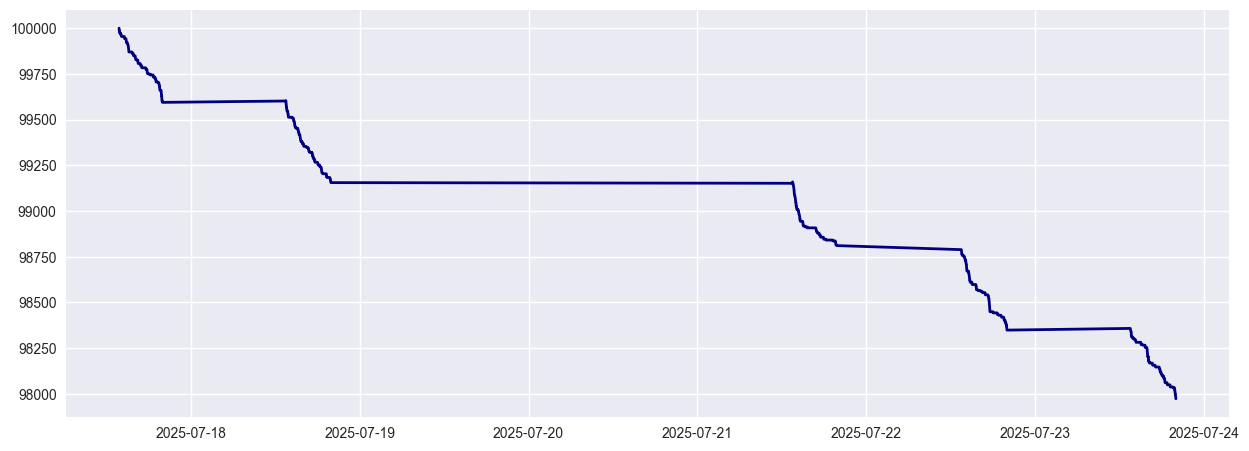

In [9]:
import backtrader as bt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec

class CustomPandasData(bt.feeds.PandasData):
    lines = ('volume_imbalance', 'log_return', 'corr_spy',)
    params = (
        ('volume_imbalance', -1),
        ('log_return', -1),
        ('corr_spy', -1),
    )

class LongShortStrategy(bt.Strategy):
    params = (
        ('period', 20),
        ('buy_threshold_volume_imbalance', 100000),
        ('sell_threshold_volume_imbalance', -100000),
        ('correlation_threshold_buy', 0.5),
        ('correlation_threshold_sell', -0.5),
        ('stake', 10),
        ('printlog', True),
        ('atr_period', 14),
        ('atr_multiplier', 2.0),
        ('exit_on_reverse_signal', False), 
    )

    def log(self, txt, dt=None, tradeid='', **kwargs):
        """logs"""
        if self.p.printlog:
            dt = dt or self.datas[0].datetime.datetime(0)
            trade_info = f" [Trade {tradeid}]" if tradeid else ""
            print(f'{dt.isoformat()}{trade_info}, {txt}')

    def __init__(self):
        """init indics."""
        self.inds = {}
        for d in self.datas:
            self.inds[d] = {
                'vi': d.lines.volume_imbalance,
                'corr': d.lines.corr_spy,
                'atr': bt.indicators.ATR(d, period=self.p.atr_period),
                'sma': bt.indicators.SMA(d.close, period=self.p.period)
            }
        
        self.trade_history = []
        # Key: Ticker, Value: trade info
        self.current_positions = {}
        self.trade_counter = 0 # for unique trade id 
        self.portfolio_values = []
        self.dates = []
        self.orders = {} # curr open orders

    def notify_order(self, order):
        """
        info about order
        """
        ticker = order.data._name

        # orders which doesnt even opened
        if order.status in [order.Submitted, order.Accepted]:
            self.orders[ticker] = order # save id on open order
            return

        # process completed orders
        if order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log(f'Order for {ticker} was {order.getstatusname()}', tradeid=order.ref)
            if ticker in self.orders and self.orders[ticker] == order:
                del self.orders[ticker] # if order is canceled, delete it
            return
        
        # Order completed
        if order.status == order.Completed:
            self.log(f'Order Completed for {ticker}: Price={order.executed.price:.2f}, Size={order.executed.size}, Comm={order.executed.comm:.2f}', tradeid=order.ref)
            
            # delete from track list bcs its completed
            if ticker in self.orders and self.orders[ticker] == order:
                del self.orders[ticker]

            # get order size on curr pos
            current_position_size = self.getposition(order.data).size

            # Buy order
            if order.isbuy():
                if current_position_size > 0 and ticker not in self.current_positions:
                    self.trade_counter += 1
                    trade_id = self.trade_counter
                    self.current_positions[ticker] = {
                        'tradeid': trade_id,
                        'type': 'LONG',
                        'entry_price': order.executed.price,
                        'size': order.executed.size,
                        'entry_time': self.datas[0].datetime.datetime(0),
                        'entry_vi': self.inds[order.data]['vi'][0],
                        'entry_corr': self.inds[order.data]['corr'][0],
                    }
                    self.log(
                        f"{ticker} LONG OPENED - Price: {order.executed.price:.2f}, Size: {order.executed.size}",
                        tradeid=trade_id
                    )
                elif current_position_size == 0 and ticker in self.current_positions and self.current_positions[ticker]['type'] == 'SHORT':
                    # close short pos
                    position = self.current_positions.pop(ticker)
                    pnl = (position['entry_price'] - order.executed.price) * position['size']
                    pnl -= order.executed.comm 
                    
                    self.trade_history.append({
                        'tradeid': position['tradeid'],
                        'ticker': ticker,
                        'type': 'SHORT',
                        'entry_price': position['entry_price'],
                        'exit_price': order.executed.price,
                        'size': position['size'],
                        'entry_time': position['entry_time'],
                        'exit_time': self.datas[0].datetime.datetime(0),
                        'pnl': pnl,
                        'entry_vi': position['entry_vi'],
                        'exit_vi': self.inds[order.data]['vi'][0],
                        'entry_corr': position['entry_corr'],
                        'exit_corr': self.inds[order.data]['corr'][0]
                    })
                    self.log(
                        f"{ticker} SHORT CLOSED - PnL: {pnl:.2f}",
                        tradeid=position['tradeid']
                    )

            # Sell order
            elif order.issell():
                if current_position_size < 0 and ticker not in self.current_positions:
                    self.trade_counter += 1
                    trade_id = self.trade_counter
                    self.current_positions[ticker] = {
                        'tradeid': trade_id,
                        'type': 'SHORT',
                        'entry_price': order.executed.price,
                        'size': order.executed.size,
                        'entry_time': self.datas[0].datetime.datetime(0),
                        'entry_vi': self.inds[order.data]['vi'][0],
                        'entry_corr': self.inds[order.data]['corr'][0],
                    }
                    self.log(
                        f"{ticker} SHORT OPENED - Price: {order.executed.price:.2f}, Size: {order.executed.size}",
                        tradeid=trade_id
                    )
                elif current_position_size == 0 and ticker in self.current_positions and self.current_positions[ticker]['type'] == 'LONG':
                    # close long pos 
                    position = self.current_positions.pop(ticker)
                    pnl = (order.executed.price - position['entry_price']) * position['size']
                    pnl -= order.executed.comm 
                    
                    self.trade_history.append({
                        'tradeid': position['tradeid'],
                        'ticker': ticker,
                        'type': 'LONG',
                        'entry_price': position['entry_price'],
                        'exit_price': order.executed.price,
                        'size': position['size'],
                        'entry_time': position['entry_time'],
                        'exit_time': self.datas[0].datetime.datetime(0),
                        'pnl': pnl,
                        'entry_vi': position['entry_vi'],
                        'exit_vi': self.inds[order.data]['vi'][0],
                        'entry_corr': position['entry_corr'],
                        'exit_corr': self.inds[order.data]['corr'][0]
                    })
                    self.log(
                        f"{ticker} LONG CLOSED - PnL: {pnl:.2f}",
                        tradeid=position['tradeid']
                    )

    def next(self):
        """algorithm of strategy runnin on every bar"""
        # Record portfolio value and date
        current_date = self.datas[0].datetime.datetime(0)
        self.dates.append(current_date)
        self.portfolio_values.append(self.broker.getvalue())

        for data in self.datas:
            ticker = data._name
            
            if ticker == 'SPY' or len(data) < max(self.p.period, self.p.atr_period, 2):
                continue

            # check if there is an active order
            if ticker in self.orders and self.orders[ticker].status in [self.orders[ticker].Submitted, self.orders[ticker].Accepted]:
                continue
            
            vi = self.inds[data]['vi'][0]
            corr = self.inds[data]['corr'][0]
            atr = self.inds[data]['atr'][0]
            sma = self.inds[data]['sma'][0]

            if any(np.isnan(x) for x in [vi, corr, atr, sma]):
                continue

            position = self.getposition(data)
            has_long_position = position.size > 0
            has_short_position = position.size < 0

            # Long conditions
            long_condition = (
                vi > self.p.buy_threshold_volume_imbalance and 
                corr > self.p.correlation_threshold_buy and
                data.close[0] > sma
            )

            # Short conditions
            short_condition = (
                vi < self.p.sell_threshold_volume_imbalance and 
                corr < self.p.correlation_threshold_sell and
                data.close[0] < sma
            )

            # logic of open pos
            if not has_long_position and not has_short_position: # no open positions
                if long_condition:
                    # Тtradi id came auto in buy/sell
                    # notify_order by itself spectate open/close 
                    self.buy(data=data, size=self.p.stake) 
                
                elif short_condition:
                    self.sell(data=data, size=self.p.stake)
            
            # logic of close pos
            else: # open pos
                if has_long_position:
                    if not long_condition or (self.p.exit_on_reverse_signal and short_condition):
                        self.close(data=data)
                        self.log(f'Attempting to close LONG position for {ticker} by signal change.', tradeid=self.current_positions.get(ticker, {}).get('tradeid'))
                
                elif has_short_position:
                    if not short_condition or (self.p.exit_on_reverse_signal and long_condition):
                        self.close(data=data)
                        self.log(f'Attempting to close SHORT position for {ticker} by signal change.', tradeid=self.current_positions.get(ticker, {}).get('tradeid'))

    def stop(self):
        """After strategy finished"""
        self.log("=== STRATEGY FINISHED ===")

        # compulsorily close all remaining open positions
        for ticker, position_info in list(self.current_positions.items()): # iterating on copies to safety delete
            data = None
            for d in self.datas:
                if d._name == ticker:
                    data = d
                    break
            
            if data and self.getposition(data).size != 0:
                self.log(f"Forcing close of {position_info['type']} position for {ticker} at end of backtest.", tradeid=position_info['tradeid'])
                self.close(data=data)
            else: # if pos was or no data
                 del self.current_positions[ticker] # checking for deleted in data

        self.log(f"Total Trades recorded in history: {len(self.trade_history)}")
        
        if self.current_positions:
            self.log(f"WARNING: Still {len(self.current_positions)} open positions after forced closure.")
            for ticker, info in self.current_positions.items():
                self.log(f"  - {ticker}: {info['type']} size {info['size']} opened at {info['entry_time']}", tradeid=info['tradeid'])


        self.plot_results()
        self.save_trades()

    def plot_results(self):
        """plotting"""
        try:
            plt.style.use('seaborn-v0_8')
            fig = plt.figure(figsize=(15, 10))
            gs = GridSpec(3, 1, figure=fig, height_ratios=[3, 1, 1])
            
            # 1. Portfolio Value with Trades
            ax1 = fig.add_subplot(gs[0, :])
            ax1.plot(self.dates, self.portfolio_values, 
                    label='Portfolio Value', linewidth=2, color='navy')
            
            if self.trade_history:
                trades_df = pd.DataFrame(self.trade_history)
                
                trades_df['entry_time'] = pd.to_datetime(trades_df['entry_time'])
                trades_df['exit_time'] = pd.to_datetime(trades_df['exit_time'])
                legend_handles = {}

                for idx, trade in trades_df.iterrows():
                    color = 'green' if trade['type'] == 'LONG' else 'red'

                    entry_label = f"{trade['type']} Entry"
                    if entry_label not in legend_handles:
                        sc = ax1.scatter(trade['entry_time'], 
                                        self.get_portfolio_value_at(trade['entry_time']), 
                                        color=color, marker='^', s=100, zorder=5)
                        legend_handles[entry_label] = sc
                    else:
                        ax1.scatter(trade['entry_time'], 
                                    self.get_portfolio_value_at(trade['entry_time']), 
                                    color=color, marker='^', s=100, zorder=5)


                    exit_label = f"{trade['type']} Exit"
                    if exit_label not in legend_handles:
                        sc = ax1.scatter(trade['exit_time'], 
                                        self.get_portfolio_value_at(trade['exit_time']), 
                                        color=color, marker='o', s=80, zorder=5)
                        legend_handles[exit_label] = sc
                    else:
                        ax1.scatter(trade['exit_time'], 
                                    self.get_portfolio_value_at(trade['exit_time']), 
                                    color=color, marker='o', s=80, zorder=5)
            
            ax1.set_title('Portfolio Performance with Trades', fontsize=14, pad=10)
            ax1.set_ylabel('Value ($)', fontsize=10)
            ax1.legend(handles=list(legend_handles.values()), labels=list(legend_handles.keys()), loc='upper left')
            ax1.grid(True, linestyle=':', alpha=0.7)
            ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
            fig.autofmt_xdate() 

            # 2. Cumulative PnL
            ax2 = fig.add_subplot(gs[1, :], sharex=ax1) 
            if self.trade_history:
                trades_df['cum_pnl'] = trades_df['pnl'].cumsum()
                ax2.plot(trades_df['exit_time'], trades_df['cum_pnl'], 
                        color='purple', linewidth=1.5)
                ax2.fill_between(trades_df['exit_time'], trades_df['cum_pnl'], 
                                where=trades_df['cum_pnl']>=0, 
                                facecolor='green', alpha=0.2)
                ax2.fill_between(trades_df['exit_time'], trades_df['cum_pnl'], 
                                where=trades_df['cum_pnl']<=0, 
                                facecolor='red', alpha=0.2)
                ax2.axhline(0, color='black', linestyle='--', linewidth=0.8)
                ax2.set_title('Cumulative Profit & Loss', fontsize=12, pad=8)
                ax2.set_ylabel('PnL ($)', fontsize=10)
                ax2.grid(True, linestyle=':', alpha=0.5)
            else:
                ax2.text(0.5, 0.5, 'No trades to plot.', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes, fontsize=12)

            # 3. Trade Activity by Hour
            ax3 = fig.add_subplot(gs[2, :])
            if self.trade_history:
                trades_df['hour'] = trades_df['entry_time'].dt.hour
                hour_dist = trades_df.groupby('hour').agg({
                    'tradeid': 'count',
                    'pnl': 'mean'
                }).reset_index()
            
                all_hours = pd.DataFrame({'hour': range(24)})
                hour_dist = pd.merge(all_hours, hour_dist, on='hour', how='left').fillna({'tradeid': 0, 'pnl': 0})

                colors = ['green' if pnl > 0 else 'red' for pnl in hour_dist['pnl']]
                ax3.bar(hour_dist['hour'], hour_dist['tradeid'], color=colors, alpha=0.7)
                
                ax3.set_title('Trade Activity by Hour (Green = Avg Profit, Red = Avg Loss)', 
                             fontsize=12, pad=8)
                ax3.set_xlabel('Hour of Day', fontsize=10)
                ax3.set_ylabel('Number of Trades', fontsize=10)
                ax3.set_xticks(range(24))
                ax3.grid(True, axis='y', linestyle=':', alpha=0.5)
            else:
                ax3.text(0.5, 0.5, 'No trades to plot.', horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes, fontsize=12)
            
            plt.tight_layout()
            plt.savefig('trading_performance.png', dpi=300, bbox_inches='tight')
            plt.close()
            print("\nPerformance chart saved to 'trading_performance.png'")
            
        except Exception as e:
            print(f"\nError in plotting: {str(e)}")

    def get_portfolio_value_at(self, dt):
        """ curr portfel balance        """
        if not self.dates:
            return self.broker.startingcash

        idx = (np.abs(np.array(self.dates) - dt)).argmin()
        return self.portfolio_values[idx]

    def save_trades(self):
        if self.trade_history:
            trades_df = pd.DataFrame(self.trade_history)
            trades_df.to_csv('trades_history.csv', index=False)
            print("Trades history saved to 'trades_history.csv'")
            
            # Performance metrics
            if len(self.portfolio_values) > 1:
                initial = self.portfolio_values[0]
                final = self.portfolio_values[-1]
                returns = (final - initial) / initial * 100
            else:
                initial = self.broker.startingcash
                final = self.broker.getvalue()
                returns = ((final - initial) / initial * 100) if initial != 0 else 0


            print("\n=== Performance Summary ===")
            print(f"Initial Capital: ${initial:,.2f}")
            print(f"Final Capital:   ${final:,.2f}")
            print(f"Total Return:    {returns:.2f}%")
            
            wins = trades_df[trades_df['pnl'] > 0]
            losses = trades_df[trades_df['pnl'] <= 0]
            
            print(f"\nTotal Trades:    {len(trades_df)}")
            if len(trades_df) > 0:
                print(f"Win Rate:        {len(wins)/len(trades_df):.1%}")
                print(f"Avg Win Trade:   ${wins['pnl'].mean():.2f}")
                print(f"Avg Loss Trade:  ${losses['pnl'].mean():.2f}")
                if losses['pnl'].sum() != 0:
                    print(f"Profit Factor:   {wins['pnl'].sum()/abs(losses['pnl'].sum()):.2f}")
                else:
                    print("Profit Factor:   N/A (No losses)")
            else:
                print("No trades to calculate detailed metrics.")

            # Max Drawdown from portfolio_values (more accurate)
            if self.portfolio_values:
                print(f"Max Drawdown:    {self.calculate_max_drawdown():.2f}%")
            else:
                print("Max Drawdown:    N/A (No portfolio values recorded)")

    def calculate_max_drawdown(self):
        """Вычисляет максимальную просадку в процентах."""
        if not self.portfolio_values:
            return 0.0
        
        peak = self.portfolio_values[0]
        max_dd = 0.0
        for value in self.portfolio_values:
            if value > peak:
                peak = value
            dd = (peak - value) / peak * 100
            if dd > max_dd:
                max_dd = dd
        return max_dd

# --- Cerebro setup ---
cerebro = bt.Cerebro()
cerebro.addstrategy(LongShortStrategy, exit_on_reverse_signal=True) 

if 'df_long_final' not in globals() or not isinstance(df_long_final, pd.DataFrame) or df_long_final.empty:
    print("Error df_lobg_final doesnt exist or NAN")
    exit()

df_long_final.sort_values(by=['datetime', 'ticker'], inplace=True)

loaded_tickers = set()

for ticker_symbol in df_long_final['ticker'].unique():
    ticker_data_df = df_long_final[df_long_final['ticker'] == ticker_symbol].copy()
    
    if 'datetime' in ticker_data_df.columns:
        ticker_data_df.set_index('datetime', inplace=True)
    
    if not isinstance(ticker_data_df.index, pd.DatetimeIndex):
        print(f"Warning: index for {ticker_symbol} not in data. skip.")
        continue

    if ticker_data_df.empty:
        print(f"warning: DataFrame for {ticker_symbol} empty after index creation. skip.")
        continue

    ticker_data_df.drop(columns=['ticker'], inplace=True, errors='ignore')

    if ticker_data_df.index.has_duplicates:
        original_rows = len(ticker_data_df)
        ticker_data_df = ticker_data_df[~ticker_data_df.index.duplicated(keep='first')]
        if len(ticker_data_df) < original_rows:
            print(f"warning: deleted duplicates for {ticker_symbol} ")

    required_cols = ['open', 'high', 'low', 'close', 'volume', 'volume_imbalance', 'log_return', 'corr_spy']
    missing_cols  = [col for col in required_cols if col not in ticker_data_df.columns]
    if missing_cols:
        print(f"warning: for {ticker_symbol} missing cols: {missing_cols}. skip.")
        continue
    
    if ticker_data_df[required_cols].isnull().any().any():
        print(f"warning: for {ticker_symbol} nan in important cols . skip.")
        continue

    min_required_rows = max(20, 14)
    if len(ticker_data_df) < min_required_rows:
        print(f"warning:for  {ticker_symbol} not enough data ({len(ticker_data_df)} rows) for init indics (need min {min_required_rows}). skip.")
        continue

    data = CustomPandasData(
        dataname=ticker_data_df,
        datetime=None, # Index is already datetime
        open='open',
        high='high',
        low='low',
        close='close',
        volume='volume',
        timeframe=bt.TimeFrame.Minutes,
        compression=1
    )
    cerebro.adddata(data, name=ticker_symbol)
    loaded_tickers.add(ticker_symbol)
    print(f"data for {ticker_symbol} completed. Period: {ticker_data_df.index.min()} - {ticker_data_df.index.max()}")

if not cerebro.datas:
    print("error, data couldnt completed by backtester")
    exit() 

# --- Broker setup ---
cerebro.broker.setcash(100000.0)
cerebro.addsizer(bt.sizers.FixedSize, stake=10)
cerebro.broker.setcommission(commission=0.001)

# --- Run backtest ---
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
results = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())


Создаю ФИКТИВНЫЕ данные для демонстрации.
Период фиктивных данных: 2024-01-01 09:30:00 - 2024-01-05 16:00:00


AttributeError: 'Cerebro' object has no attribute 'strategy_params'